## **2. Cross-sample analysis**

In this tutorial, we demonstrate how to perform prediction and evaluation on cross-sample scenario. We train XChrom model using one sample and then using another independent sample as the test set to evaluate the model’s transferability to different samples, thereby illustrating the model's performance in handling data with inherent batch effects.

We utilized a publicly available dataset of single-cell multiome data collected from bone marrow mononuclear cells (BMMCs) of 12 healthy human donors. The dataset includes multiple batches arising from donor sources and sequencing platforms. All samples were prepared using a standardized protocol. The data was subsequently annotated to identify cell types and remove doublets.

- **Data Preprocessing**                                       
    - As an example, we extracted two samples labeled `s1d1` and `s2d1` (where `s` denotes sequencing site and `d` denotes donor). We used `s1d1` as the training set and `s2d1` as the test set. For the training scATAC-seq data, we performed partitioning by cells and peaks to generate training/validation data for model input, following the same procedure described in the `1_Within-sample analysis` tutorial. For the test scATAC-seq data, we used the entire test set for evaluation.                                                 
    - For the scRNA-seq data, we first performed batch effect correction on both `s1d1` and `s2d1` samples using Harmony (though alternative methods such as Scanorama, scVI, or ingest could be employed). The batch-corrected cell embeddings-typically named `'X_pca_harmony'`-were stored in the respective scRNA-seq datasets of both samples and served as input for model training and prediction.

- **Model Training**                                    
XChrom takes two inputs: ① DNA sequences (one-hot encoded, 1 × 1344bp) and ② cell embeddings (cell number × 32). The model is trained to predict chromatin accessibility probabilities for each genomic region across all cells. Importantly, the cell embeddings used here are derived from batch-corrected scRNA-seq data from both samples.

- **Prediction and Evaluation**                   
After training, we evaluate the preprocessed test sample from two perspectives:                              
    - **Binary classification metrics:** auROC and auPRC, as primary evaluation metrics, which were summarized at the overall, per-cell and per-peak levels.
    - **Cell state fidelity:** Using the neighbor score (NS) to quantify cross-modality neighborhood concordance by comparing scATAC-seq and scRNA-seq data, and the label score (LS) to evaluate the consistency of cell-type labels within local neighborhoods.Both metrics depend on a parameter k, the number of nearest neighbors in the cell-cell graph.

### 1. Download Data (BMMCs: s1d1-s2d1)  
- The original data is sourced from [GEO accession GSE194122](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE194122). We extracted samples s1d1 and s2d1 from this dataset and made them available at: https://doi.org/10.5281/zenodo.16959682.  
- After downloading, save the data as `'./data/2_cross_samples/s1d1_s2d1.h5ad'`.  
- Download the human genome file from:  
  [https://hgdownload.soe.ucsc.edu/goldenPath/hg38/bigZips/hg38.fa.gz](https://hgdownload.soe.ucsc.edu/goldenPath/hg38/bigZips/hg38.fa.gz)  
  and decompress it.

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="3,2,1,0"  

In [2]:
import xchrom as xc
import scanpy as sc
import scanpy.external as sce

### 2. Read and filter data

In [3]:
adata = sc.read_h5ad('./data/2_cross_samples/s1d1_s2d1.h5ad')
adata

AnnData object with n_obs × n_vars = 10444 × 129921
    obs: 'cell_type', 'batch', 'Samplename'
    var: 'feature_types', 'gene_id'

In [4]:
adata_rna = adata[:, adata.var['feature_types']=='GEX']
adata_atac = adata[:, adata.var['feature_types']=='ATAC']

In [5]:
## Break down the features in var into chr, start, and end
features = adata_atac.var.index
chromosome_start_end = features.str.split("-", n=2, expand=True)
chromosome_start_end_df = chromosome_start_end.to_frame(index=False)
chromosome_start_end_df.columns = ["chr", "start", "end"]
chromosome_start_end_df.index = adata_atac.var.index
adata_atac.var['chr'] = chromosome_start_end_df['chr']
adata_atac.var['start'] = chromosome_start_end_df['start'].astype(int)
adata_atac.var['end'] = chromosome_start_end_df['end'].astype(int)
print(adata_atac.var[['chr', 'start', 'end']].head())

/tmp/ipykernel_61297/2766228937.py:7: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata_atac.var['chr'] = chromosome_start_end_df['chr']


                     chr   start     end
chr1-9776-10668     chr1    9776   10668
chr1-180726-181005  chr1  180726  181005
chr1-181117-181803  chr1  181117  181803
chr1-191133-192055  chr1  191133  192055
chr1-267562-268456  chr1  267562  268456


In [6]:
adata_rna

View of AnnData object with n_obs × n_vars = 10444 × 13431
    obs: 'cell_type', 'batch', 'Samplename'
    var: 'feature_types', 'gene_id'

In [7]:
train_rna = adata_rna[adata_rna.obs['Samplename'] == 'site1_donor1_multiome']
train_atac = adata_atac[adata_atac.obs['Samplename'] == 'site1_donor1_multiome']
test_rna = adata_rna[adata_rna.obs['Samplename'] == 'site2_donor1_multiome']
test_atac = adata_atac[adata_atac.obs['Samplename'] == 'site2_donor1_multiome']

In [8]:
train_rna,train_atac,test_rna,test_atac

(View of AnnData object with n_obs × n_vars = 6224 × 13431
     obs: 'cell_type', 'batch', 'Samplename'
     var: 'feature_types', 'gene_id',
 View of AnnData object with n_obs × n_vars = 6224 × 116490
     obs: 'cell_type', 'batch', 'Samplename'
     var: 'feature_types', 'gene_id', 'chr', 'start', 'end',
 View of AnnData object with n_obs × n_vars = 4220 × 13431
     obs: 'cell_type', 'batch', 'Samplename'
     var: 'feature_types', 'gene_id',
 View of AnnData object with n_obs × n_vars = 4220 × 116490
     obs: 'cell_type', 'batch', 'Samplename'
     var: 'feature_types', 'gene_id', 'chr', 'start', 'end')

In [9]:
### filter data
train_rna, train_atac = xc.pp.filter_multiome_data(
    ad_rna = train_rna,
    ad_atac = train_atac,
    species = 'human',
    filter_ratio = 0.01
)

RNA data after filtering: View of AnnData object with n_obs × n_vars = 6224 × 12228
    obs: 'cell_type', 'batch', 'Samplename', 'n_genes'
    var: 'feature_types', 'gene_id', 'n_cells'
ATAC data after filtering: View of AnnData object with n_obs × n_vars = 6224 × 51571
    obs: 'cell_type', 'batch', 'Samplename', 'n_genes'
    var: 'feature_types', 'gene_id', 'chr', 'start', 'end', 'n_cells'


In [10]:
test_rna, test_atac = xc.pp.filter_multiome_data(
    ad_rna = test_rna,
    ad_atac = test_atac,
    species = 'human',
    filter_ratio = 0.01
)

RNA data after filtering: View of AnnData object with n_obs × n_vars = 4220 × 12210
    obs: 'cell_type', 'batch', 'Samplename', 'n_genes'
    var: 'feature_types', 'gene_id', 'n_cells'
ATAC data after filtering: View of AnnData object with n_obs × n_vars = 4220 × 56439
    obs: 'cell_type', 'batch', 'Samplename', 'n_genes'
    var: 'feature_types', 'gene_id', 'chr', 'start', 'end', 'n_cells'


In [11]:
train_atac.write('./data/2_cross_samples/train_atac.h5ad')
test_atac.write('./data/2_cross_samples/test_atac.h5ad')

/home/miaoyuanyuan/miniconda3/envs/py3.8_tf2.6.0/lib/python3.8/site-packages/anndata/_core/anndata.py:1230: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  df[key] = c
/home/miaoyuanyuan/miniconda3/envs/py3.8_tf2.6.0/lib/python3.8/site-packages/anndata/_core/anndata.py:1230: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  df[key] = c


Filtering was performed on the scATAC data of both the training and testing samples separately. We removed peaks accessible in fewer than 1% of cells and excluded sequences not belonging to chromosomes chr1-22, X, or Y. The filtered scATAC data was saved in `'./data/2_cross_samples'`.

Similarly, the scRNA data of both training and testing samples were filtered to remove genes expressed in fewer than 1% of cells.

### 3. Process scRNA-seq data to generate raw cell embeddings (2 samples batch correction)

We use Harmony to correct batch effects between the two samples. After filtering, we concatenate the samples, perform PCA (e.g., 32 components) to embed the transcriptomic profiles, and then run Harmony on the PCs to iteratively remove dataset-specific effects. This yields batch-corrected embeddings stored as `RNA.obsm['X_pca_harmony']`, which represent each cell and serve as the raw cell embeddings for subsequent model input.
- Alternatively, latent embeddings from other integration methods—such as scVI or biology foundation models—can also be used as raw cell embeddings. Save the resulting array in `RNA.obsm[cellembed_raw]` (shape: n_cells × d) so the model can access it.

/home/miaoyuanyuan/miniconda3/envs/py3.8_tf2.6.0/lib/python3.8/site-packages/anndata/_core/anndata.py:1763: FutureWarning: The AnnData.concatenate method is deprecated in favour of the anndata.concat function. Please use anndata.concat instead.

See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  warnings.warn(
/home/miaoyuanyuan/miniconda3/envs/py3.8_tf2.6.0/lib/python3.8/site-packages/scanpy/preprocessing/_simple.py:842: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


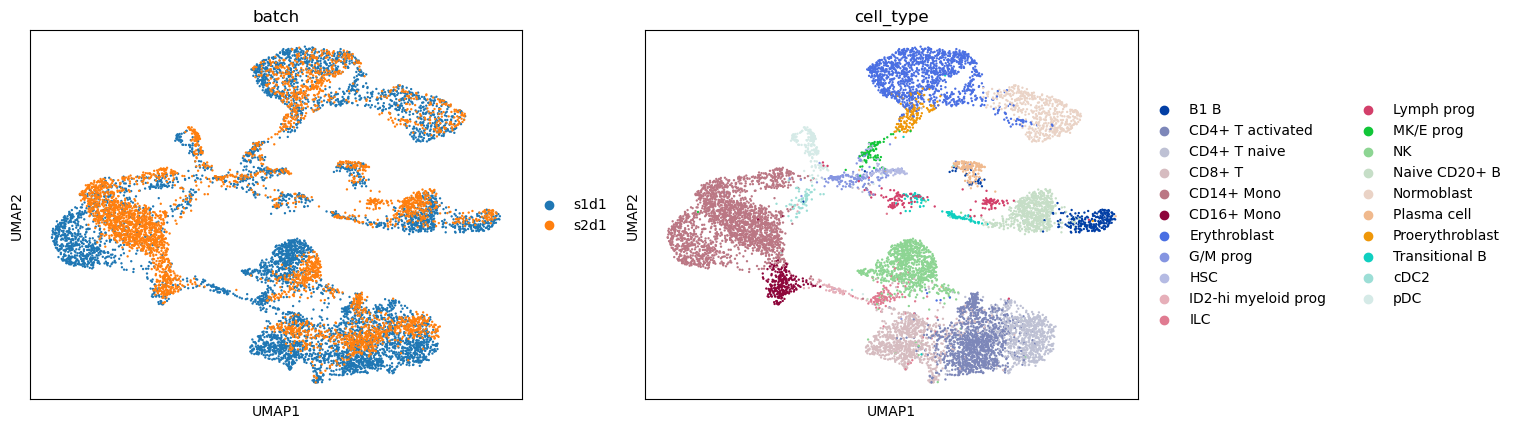

In [12]:
rna = train_rna.concatenate(test_rna, batch_key="batchid")
rna = xc.tl.calc_pca(rna, n_comps=32, max_value=10)
# Calculate the neighbors based on the PCA space before batch correction
sc.pp.neighbors(rna, use_rep='X_pca')
sc.tl.umap(rna)
sc.pl.umap(rna, color=['batch','cell_type'])

In [13]:
# batch correction
sce.pp.harmony_integrate(rna, 'batchid')
'X_pca_harmony' in rna.obsm

2025-08-17 15:28:50,221 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2025-08-17 15:28:52,369 - harmonypy - INFO - sklearn.KMeans initialization complete.
2025-08-17 15:28:52,435 - harmonypy - INFO - Iteration 1 of 10
2025-08-17 15:28:54,739 - harmonypy - INFO - Iteration 2 of 10
2025-08-17 15:28:57,068 - harmonypy - INFO - Iteration 3 of 10
2025-08-17 15:28:59,430 - harmonypy - INFO - Converged after 3 iterations


True

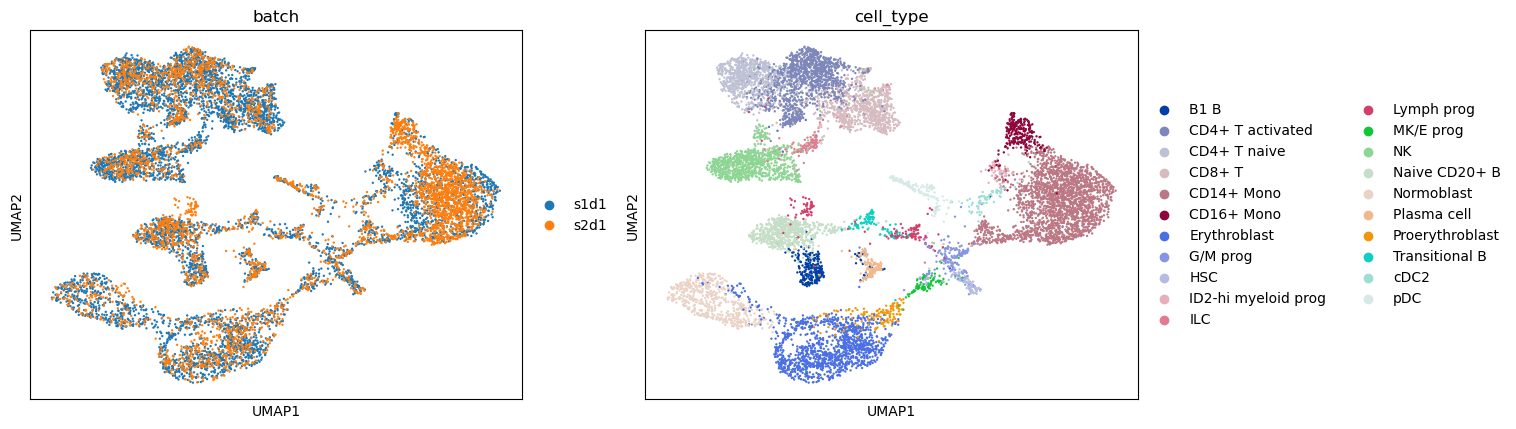

In [14]:
# Calculate the neighbors based on the PCA space after batch correction
sc.pp.neighbors(rna, use_rep='X_pca_harmony')
sc.tl.umap(rna)
sc.pl.umap(rna, color=['batch','cell_type'])

In [15]:
rna.obs.index = rna.obs.index.str.replace(r'-\d+$', '', regex=True)
train_rna = rna[rna.obs['batch']=='s1d1']
test_rna = rna[rna.obs['batch']=='s2d1']
train_rna.write('./data/2_cross_samples/train_rna_harmony.h5ad')
test_rna.write('./data/2_cross_samples/test_rna_harmony.h5ad')

Now we have raw cell embeddings in `RNA.obsm['X_pca_harmony']`, and cell types in `RNA.obs['cell_type']` as labels.

### 4. Training/test data prepare

In [16]:
## generate data for model training
train_folder = './data/2_cross_samples/train_data/'
input_fasta = '/picb/bigdata/project/miaoyuanyuan/hg38.fa'
train_atac = sc.read_h5ad('./data/2_cross_samples/train_atac.h5ad')
dict = xc.pp.process_train_test_single(
    ad_atac=train_atac, ## can be a str, Path, or anndata.AnnData object
    input_fasta=input_fasta,
    output_path=train_folder
)

train/test data is saved in:  data/2_cross_samples/train_data
successful writing bed file.
successful writing train/test split file.
successful writing train/test anndata file.
successful writing sparse m.
Successfully saving all sequence h5 file...
Successfully saving trainval sequence h5 file...
Successfully saving test sequence h5 file...


In [17]:
## generate data for model evaluation
test_folder = './data/2_cross_samples/test_data/'
test_atac = sc.read_h5ad('./data/2_cross_samples/test_atac.h5ad')
dict = xc.pp.process_test_dual(
    ad_atac=test_atac, ## can be a str, Path, or anndata.AnnData object
    input_fasta=input_fasta,
    output_path=test_folder
)

train/test data is saved in:  data/2_cross_samples/test_data
successful writing bed file.
successful writing sparse m.
start saving all sequence h5 file...


We performed preprocessing on the filtered scATAC data of s1d1 and s2d1 samples separately:  

**For the s1d1 training sample:**  
Following the same procedure as in the `1_Within-sample analysis` tutorial, we partitioned the data using 90% of cells and 90% of peaks to generate train_val sets. This produced:  
- `ad_trainval.h5ad`: containing training cells and training peaks  
- `m_trainval.npz`: corresponding count matrix  
- `trainval_seqs.h5`: base sequence file for training peaks  

All files were saved in `'./data/2_cross_samples/train_data/'`.  

**For the s2d1 test sample:**  
No partitioning was applied. The filtered scATAC data was directly converted into the required model input files:  
- `ad.h5ad`  
- `m.npz`  
- `all_seqs.h5`  

These files were saved in `'./data/2_cross_samples/test_data/'`.  

Note: The `input_fasta` parameter should be replaced with the path to the genome file corresponding to the species used in your dataset.

### 5. Train XChrom

- We use the preprocessed data from the s1d1 training set obtained above as sequence inputs for the model. The `input_folder` should contain all files generated during preprocessing. The batch-corrected `X_pca_harmony` embeddings derived from scRNA data are used as raw cell embeddings and serve as cell identity inputs to the model. If using dimensionality reduction results from other methods, they must be stored in `cell_embedding_ad.obsm` under the key `cellembed_raw` for extraction.                      

- If you want to compute NS(k=100) and LS(k=100) for monitoring the XChrom training process, you need to set `trackscore = True` and specify the `celltype` in either the RNA or ATAC H5AD file.                           

- The model is set to train for 1000 epochs by default, but an early stopping mechanism will be triggered if the increase in training auROC remains below 1e-6 for 50 consecutive epochs.                               
        
- The `save_freq` parameter determines the frequency of saving model parameters, with a default value of 1000 (meaning intermediate model parameters are not saved during training).

In [18]:
history = xc.tr.train_XChrom(
    input_folder='./data/2_cross_samples/train_data/',
    cell_embedding_ad='./data/2_cross_samples/train_rna_harmony.h5ad',
    cellembed_raw='X_pca_harmony',
    out_path='./data/2_cross_samples/train_out/',
    epochs = 1000,
    verbose = 1
)

=== Start training XChrom model ===
Input folder: /picb/bigdata/project/miaoyuanyuan/train/XChrom_test/XChrom/source/Tutorials/data/2_cross_samples/train_data
Cell embedding file: /picb/bigdata/project/miaoyuanyuan/train/XChrom_test/XChrom/source/Tutorials/data/2_cross_samples/train_rna_harmony.h5ad
Raw cell embedding key: X_pca_harmony
Output path: /picb/bigdata/project/miaoyuanyuan/train/XChrom_test/XChrom/source/Tutorials/data/2_cross_samples/train_out
Model parameters: bottleneck=32, batch_size=128, lr=0.01
1. Load raw cell embedding and make z-score normalization...
Raw cell embedding saved to: /picb/bigdata/project/miaoyuanyuan/train/XChrom_test/XChrom/source/Tutorials/data/2_cross_samples/train_rna_harmony.h5ad.obsm['X_pca_harmony']
Initial cell embedding saved to: /picb/bigdata/project/miaoyuanyuan/train/XChrom_test/XChrom/source/Tutorials/data/2_cross_samples/train_rna_harmony.h5ad.obsm['zscore32_perpc']
Initial cell embedding shape: (6224, 32)
2. Load training data...
3. Prep

2025-08-17 15:34:12.915082: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-08-17 15:34:14.522287: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 21971 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:b1:00.0, compute capability: 8.6
2025-08-17 15:34:14.522987: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 21971 MB memory:  -> device: 1, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:98:00.0, compute capability: 8.6
2025-08-17 15:34:14.523430: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:l

5. Build and compile model...
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
sequence (InputLayer)           [(None, 1344, 4)]    0                                            
__________________________________________________________________________________________________
stochastic_reverse_complement ( ((None, 1344, 4), () 0           sequence[0][0]                   
__________________________________________________________________________________________________
stochastic_shift (StochasticShi (None, 1344, 4)      0           stochastic_reverse_complement[0][
__________________________________________________________________________________________________
gelu (GELU)                     (None, 1344, 4)      0           stochastic_shift[0][0]           
________________________________________________________________

2025-08-17 15:34:18.467559: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2025-08-17 15:34:22.797225: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8800
2025-08-17 15:34:22.878255: I tensorflow/stream_executor/cuda/cuda_blas.cc:1760] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.


327/327 [==============================] - 91s 247ms/step - loss: 0.2058 - binary_accuracy: 0.9409 - auc: 0.7443 - pr: 0.1537 - val_loss: 0.1866 - val_binary_accuracy: 0.9435 - val_auc: 0.7863 - val_pr: 0.2148
Epoch 2/1000
327/327 [==============================] - 76s 221ms/step - loss: 0.1875 - binary_accuracy: 0.9434 - auc: 0.7810 - pr: 0.2166 - val_loss: 0.1847 - val_binary_accuracy: 0.9436 - val_auc: 0.7932 - val_pr: 0.2300
Epoch 3/1000
327/327 [==============================] - 74s 219ms/step - loss: 0.1852 - binary_accuracy: 0.9434 - auc: 0.7884 - pr: 0.2288 - val_loss: 0.1841 - val_binary_accuracy: 0.9435 - val_auc: 0.7944 - val_pr: 0.2306
Epoch 4/1000
327/327 [==============================] - 77s 230ms/step - loss: 0.1843 - binary_accuracy: 0.9435 - auc: 0.7911 - pr: 0.2329 - val_loss: 0.1837 - val_binary_accuracy: 0.9435 - val_auc: 0.7948 - val_pr: 0.2304
Epoch 5/1000
327/327 [==============================] - 79s 233ms/step - loss: 0.1838 - binary_accuracy: 0.9435 - auc: 0.

Plotting training metrics to monitor overfitting and evaluate the final model performance. Ideally, after a certain number of epochs, the validation curves plateau (i.e., remain stable).

The metrics computed during training are saved in `./data/2_cross_samples/train_out/history.pickle`. Load them with:     

```python
import pickle
with open('./data/2_cross_samples/train_out/history.pickle', 'rb') as f:
    history = pickle.load(f)
```

You can then use this `history` object to plot training/validation metrics (e.g., loss, auROC/auPRC, NS/LS) over epochs.                   

The function `plot_train_history()` will automatically detect whether NS and LS values have been computed during training. If these metrics are available in the history data, they will be automatically included in the training metric plots along with other evaluation metrics such as loss, auROC, and auPRC.                        

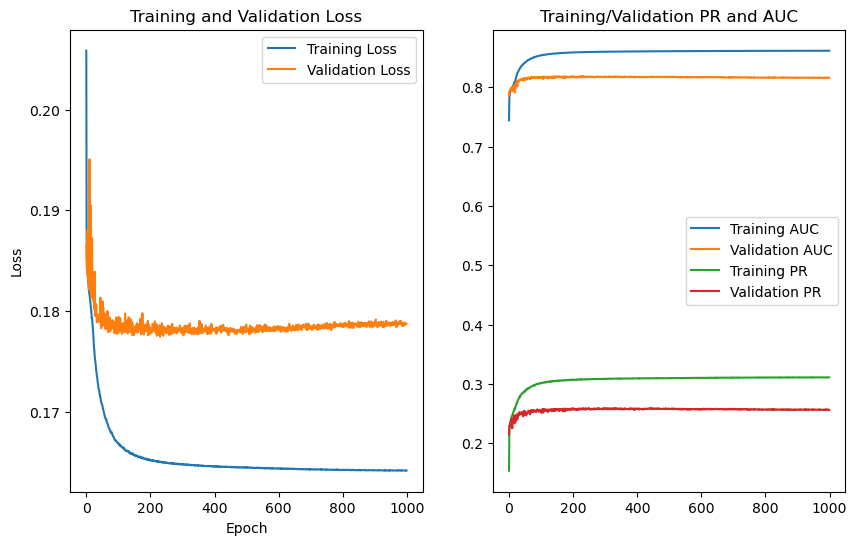

In [19]:
xc.pl.plot_train_history(
    history = history['history'],
    savefig = True,
    out_file = './data/2_cross_samples/train_out/train_history_plot.pdf'
    )

### 6. Evaluate model performance in cross-sample scenario

The following metrics will be computed on the s2d1 test set data:

- **Binary classification metrics**:  
  - (overall, per cell, per peak) auROC                          
  - (overall, per cell, per peak) auPRC                      
  
- **Cell state fidelity**:  
  - Neighbor Score (NS) (k=10, 50, 100)                     
  - Label Score (LS) (k=10, 50, 100)                                 

This combination of binary classification metrics and cell state fidelity provides a comprehensive evaluation of the model's performance on unseen data from a different sample. 

Predict done! prediction shape is: (56439, 4220)
Overall auROC: 0.8363, auPRC: 0.2284
Per-cell auROC: 0.7982, auPRC: 0.1614
Valid cells: 4220
Per-peak auROC: 0.7544, auPRC: 0.1154
Valid peaks: 56439


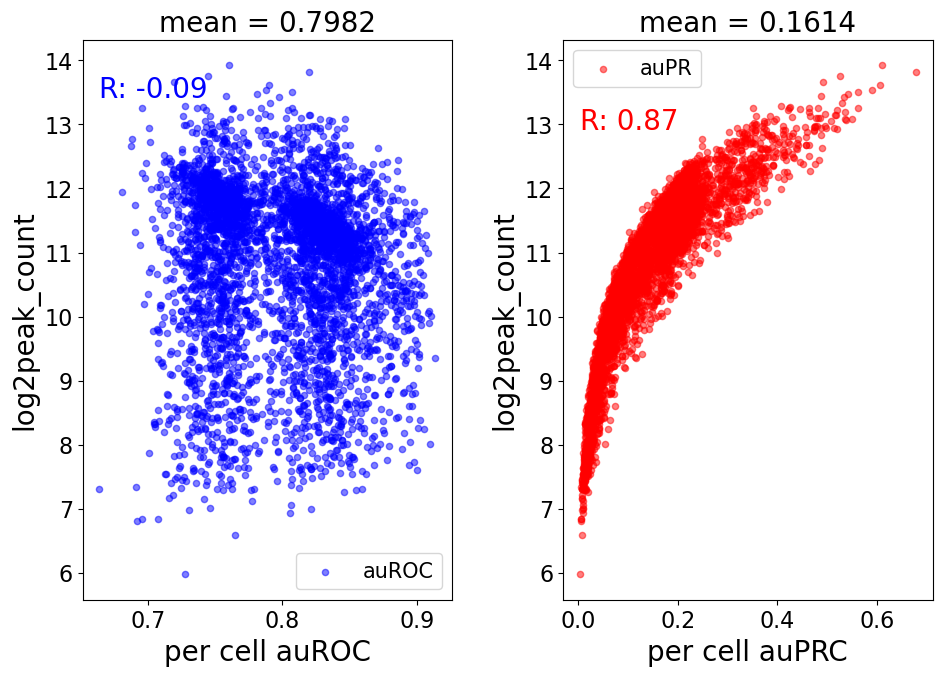

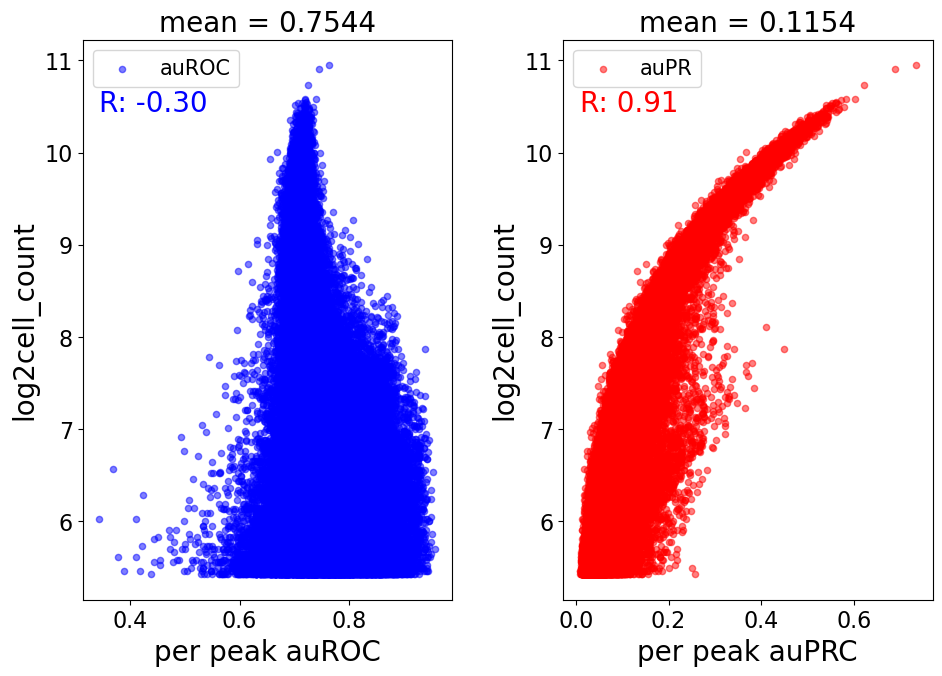

In [20]:
#### 1- calculate cross-samples auROC & auPRC
metrics1 = xc.tl.crosssamples_aucprc(
    cell_embedding_ad='./data/2_cross_samples/test_rna_harmony.h5ad',
    input_folder='./data/2_cross_samples/test_data',
    model_path='./data/2_cross_samples/train_out/E1000best_model.h5',
    output_path='./data/2_cross_samples/eval_out',
    cellembed_raw='X_pca_harmony',
    save_pred=True,
    scatter_plot=True
    )

- If `save_pred=True`, the prediction results will be saved as:   
  - `/2_cross_samples/eval_out/crosssamples_pred.npy`  
- If `scatter_plot=True`, the following relationships will be visualized and saved as PDF files in `/2_cross_samples/eval_out/`:  
  - (i) auROC per cell vs. log-transformed peak counts per cell; 
  - (ii) auPRC per cell vs. log-transformed peak counts per cell; 
  - (iii) auROC per peak vs. log-transformed cell counts per peak; 
  - (iv) auPRC per peak vs. log-transformed cell counts per peak. 

Predict done! prediction shape is: (56439, 4220)


/home/miaoyuanyuan/miniconda3/envs/py3.8_tf2.6.0/lib/python3.8/site-packages/scanpy/preprocessing/_simple.py:842: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


neighbor score(100)=0.3999,label score(100)=0.8042
neighbor score(50)=0.3094,label score(50)=0.8397
neighbor score(10)=0.1630,label score(10)=0.8799


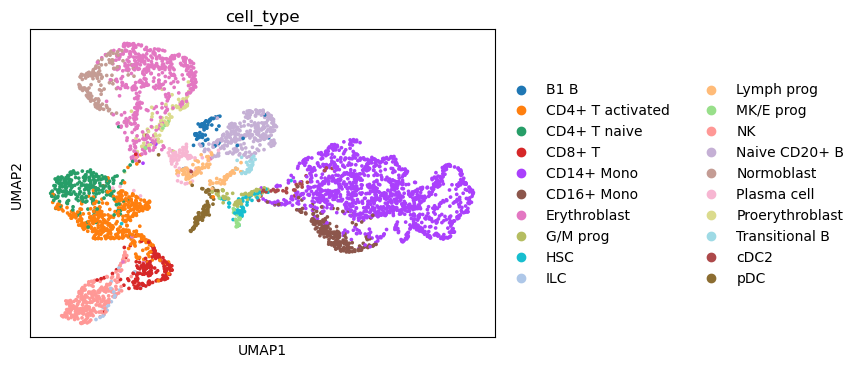

In [21]:
#### 2- calculate cross-samples ns & ls
metrics2 = xc.tl.crosssamples_nsls(
    cell_embedding_ad='./data/2_cross_samples/test_rna_harmony.h5ad',
    input_folder='./data/2_cross_samples/test_data',
    model_path='./data/2_cross_samples/train_out/E1000best_model.h5',
    output_path='./data/2_cross_samples/eval_out',
    cellembed_raw='X_pca_harmony',
    celltype = 'cell_type',
    save_pred=True,
    plot_umap=True
    )

- If `save_pred=True`, the prediction results will be saved as:   
  - `/2_cross_samples/eval_out/crosssamples_impute.h5ad`  